In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ys19-2023-assignment-2/sample_submission.csv
/kaggle/input/ys19-2023-assignment-2/test_set.csv
/kaggle/input/ys19-2023-assignment-2/valid_set.csv
/kaggle/input/ys19-2023-assignment-2/train_set.csv


In [2]:
# spaCy for Greek language handling
!python -m spacy download el_core_news_md
# pandarallel for faster applying of functions to dataframes. Need for tokens, lemmas etc.
!pip install unidecode
!pip install pandarallel
!pip install torch
!pip install gensim

print("\n")
print("INSTALLATIONS COMPLETE.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 MB 22.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_md')
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=43feccb28656c7a512fb0a38b25699fed3e6435e5ec18e41d79fb51c917990a7
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


INSTALLATIONS COMPLETE.


## Imports

In [3]:
import spacy
from pandarallel import pandarallel
from sklearn.linear_model import LogisticRegression
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score,roc_curve
from matplotlib import pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import unicodedata as ud
from unidecode import unidecode
from sklearn.model_selection import GridSearchCV
import optuna
from scipy.sparse import hstack
import nltk
import random

# HW2 new imports
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.nn.functional as F

print('Imports done.')

Imports done.


## Data Preprocessing

In [4]:
nlp = spacy.load('el_core_news_md')
df = pd.read_csv('/kaggle/input/ys19-2023-assignment-2/train_set.csv')
valid_df = pd.read_csv('/kaggle/input/ys19-2023-assignment-2/valid_set.csv')
test_df = pd.read_csv('/kaggle/input/ys19-2023-assignment-2/test_set.csv')

df.head()

,New_ID,Text,Sentiment,Party
0,35027,#απολυμανση_κοριοι #απεντομωση_κοριος #απολυμα...,NEUTRAL,SYRIZA
1,9531,Έξι νέες επιστολές για τη Μακεδονία «καίνε» τη...,NEGATIVE,ND
2,14146,"Ισχυρό ΚΚΕ, δύναμη του λαού στη Βουλή και στου...",POSITIVE,KKE
3,28716,@five2nds @anthi7vas Μνημονιακότατο το #ΜεΡΑ25...,NEUTRAL,KKE
4,32886,@ai_katerina Αυτό που είναι συγκλονιστικό είνα...,NEUTRAL,SYRIZA


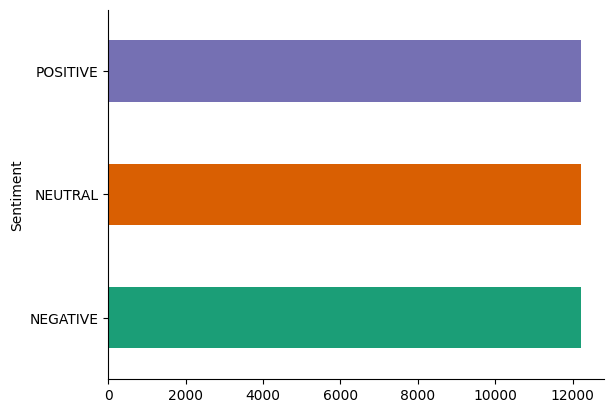

In [5]:
# Visualize our data (specifically the Sentiment column)
# Data Distribution

df.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<Axes: xlabel='Sentiment', ylabel='count'>

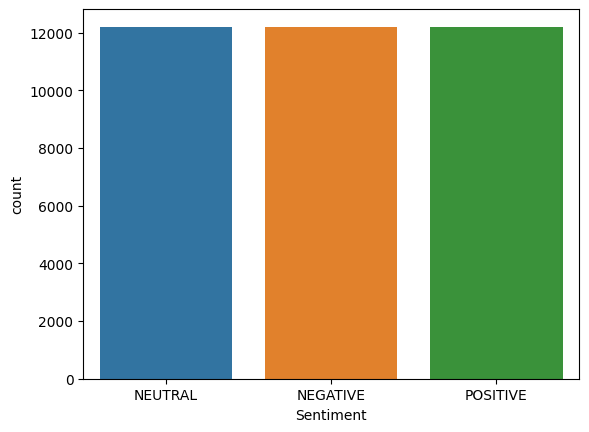

In [6]:
# Countplot for column Sentiment, Sentiment values are of the same number for each sentiment
sns.countplot(x='Sentiment',data=df)

<Axes: xlabel='Party', ylabel='count'>

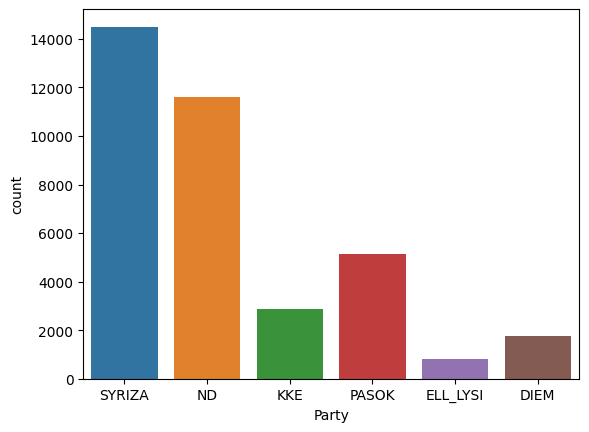

In [7]:
# Countplot for Parties , We can see that SYRIZA is the most prevalent party in the tweets dataset
sns.countplot(x='Party',data=df)

In [8]:
# Check for null values
df.isnull().sum()

# Create stop word list for word cloud and word frequency
stop_words = 'amp,αδιακοπα, αι, ακομα, ακομη, ακριβως, αληθεια, αληθινα, αλλα, αλλαχου, αλλες, αλλη, αλλην, αλλης, αλλιως, αλλιωτικα, αλλο, αλλοι, αλλοιως, αλλοιωτικα, αλλον, αλλος, αλλοτε, αλλου, αλλους, αλλων, αμα, αμεσα, αμεσως, αν, ανα, αναμεσα, αναμεταξυ, ανευ, αντι, αντιπερα, αντις, ανω, ανωτερω, αξαφνα, απ, απεναντι, απο, αποψε, αρα, αραγε, αργα, αργοτερο, αριστερα, αρκετα, αρχικα, ας, αυριο, αυτα, αυτες, αυτη, αυτην, αυτης, αυτο, αυτοι, αυτον, αυτος, αυτου, αυτους, αυτων, αφοτου, αφου, βεβαια, βεβαιοτατα, γι, για, γρηγορα, γυρω, δα, δε, δεινα, δεν, δεξια, δηθεν, δηλαδη, δι, δια, διαρκως, δικα, δικο, δικοι, δικος, δικου, δικους, διολου, διπλα, διχως, εαν, εαυτο, εαυτον, εαυτου, εαυτους, εαυτων, εγκαιρα, εγκαιρως, εγω, εδω, ειδεμη, ειθε, ειμαι, ειμαστε, ειναι, εις, εισαι, εισαστε, ειστε, ειτε, ειχα, ειχαμε, ειχαν, ειχατε, ειχε, ειχες, εκαστα, εκαστες, εκαστη, εκαστην, εκαστης, εκαστο, εκαστοι, εκαστον, εκαστος, εκαστου, εκαστους, εκαστων, εκει, εκεινα, εκεινες, εκεινη, εκεινην, εκεινης, εκεινο, εκεινοι, εκεινον, εκεινος, εκεινου, εκεινους, εκεινων, εκτος, εμας, εμεις, εμενα, εμπρος, εν, ενα, εναν, ενας, ενος, εντελως, εντος, εντωμεταξυ, ενω, εξ, εξαφνα, εξης, εξισου, εξω, επανω, επειδη, επειτα, επι, επισης, επομενως, εσας, εσεις, εσενα, εστω, εσυ, ετερα, ετεραι, ετερας, ετερες, ετερη, ετερης, ετερο, ετεροι, ετερον, ετερος, ετερου, ετερους, ετερων, ετουτα, ετουτες, ετουτη, ετουτην, ετουτης, ετουτο, ετουτοι, ετουτον, ετουτος, ετουτου, ετουτους, ετουτων, ετσι, ευγε, ευθυς, ευτυχως, εφεξης, εχει, εχεις, εχετε, εχθες, εχομε, εχουμε, εχουν, εχτες, εχω, εως, η, ηδη, ημασταν, ημαστε, ημουν, ησασταν, ησαστε, ησουν, ηταν, ητανε, ητοι, ηττον, θα, ι, ιδια, ιδιαν, ιδιας, ιδιες, ιδιο, ιδιοι, ιδιον, ιδιος, ιδιου, ιδιους, ιδιων, ιδιως, ιι, ιιι, ισαμε, ισια, ισως,κ,καθε, καθεμια, καθεμιας, καθενα, καθενας, καθενος, καθετι, καθολου, καθως, και, κακα, κακως, καλα, καλως, καμια, καμιαν, καμιας, καμποσα, καμποσες, καμποση, καμποσην, καμποσης, καμποσο, καμποσοι, καμποσον, καμποσος, καμποσου, καμποσους, καμποσων, κανεις, κανεν, κανενα, κανεναν, κανενας, κανενος, καποια, καποιαν, καποιας, καποιες, καποιο, καποιοι, καποιον, καποιος, καποιου, καποιους, καποιων, καποτε, καπου, καπως, κατ ,κατα, κατι, κατιτι, κατοπιν, κατω, κιολας,κι, κλπ, κοντα, κτλ, κυριως, λιγακι, λιγο, λιγωτερο, λογω, λοιπα, λοιπον, μα, μαζι, μακαρι, μακρυα, μαλιστα, μαλλον, μας, με, μεθαυριο, μειον, μελει, μελλεται, μεμιας, μεν, μερικα, μερικες, μερικοι, μερικους, μερικων, μεσα, μετ, μετα, μεταξυ, μεχρι, μη, μηδε, μην, μηπως, μητε, μια, μιαν, μιας, μολις, μολονοτι, μοναχα, μονες, μονη, μονην, μονης, μονο, μονοι, μονομιας, μονος, μονου, μονους, μονων, μου, μπορει, μπορουν, μπραβο, μπρος, να, ναι, νωρις, ξανα, ξαφνικα, ο, οι, ολα, ολες, ολη, ολην, ολης, ολο, ολογυρα, ολοι, ολον, ολονεν, ολος, ολοτελα, ολου, ολους, ολων, ολως, ολωσδιολου, ομως, οποια, οποιαδηποτε, οποιαν, οποιανδηποτε, οποιας, οποιασδηποτε, οποιδηποτε, οποιες, οποιεσδηποτε, οποιο, οποιοδηποτε, οποιοι, οποιον, οποιονδηποτε, οποιος, οποιοσδηποτε, οποιου, οποιουδηποτε, οποιους, οποιουσδηποτε, οποιων, οποιωνδηποτε, οποτε, οποτεδηποτε, οπου, οπουδηποτε, οπως, ορισμενα, ορισμενες, ορισμενων, ορισμενως, οσα, οσαδηποτε, οσες, οσεσδηποτε, οση, οσηδηποτε, οσην, οσηνδηποτε, οσης, οσησδηποτε, οσο, οσοδηποτε, οσοι, οσοιδηποτε, οσον, οσονδηποτε, οσος, οσοσδηποτε, οσου, οσουδηποτε, οσους, οσουσδηποτε, οσων, οσωνδηποτε, οταν, οτι, οτιδηποτε, οτου, ου, ουδε, ουτε, οχι, παλι, παντοτε, παντου, παντως, παρα, περα, περι, περιπου, περισσοτερο, περσι, περυσι, πια, πιθανον, πιο, πισω, πλαι, πλεον, πλην, ποια, ποιαν, ποιας, ποιες, ποιο, ποιοι, ποιον, ποιος, ποιου, ποιους, ποιων, πολυ, ποσες, ποση, ποσην, ποσης, ποσοι, ποσος, ποσους, ποτε, που, πουθε, πουθενα, πρεπει, πριν, προ, προκειμενου, προκειται, προπερσι, προς, προτου, προχθες, προχτες, πρωτυτερα, πως, σαν, σας, σε, σεις, σημερα, σιγα, σου, στα, στη, στην, στης, στις, στο, στον, στου, στους, στων, συγχρονως, συν, συναμα, συνεπως, συνηθως, συχνα, συχνας, συχνες, συχνη, συχνην, συχνης, συχνο, συχνοι, συχνον, συχνος, συχνου, συχνου, συχνους, συχνων, συχνως, σχεδον, σωστα, τα, ταδε, ταυτα, ταυτες, ταυτη, ταυτην, ταυτης, ταυτο,ταυτον, ταυτος, ταυτου, ταυτων, ταχα, ταχατε, τελικα, τελικως, τες, τετοια, τετοιαν, τετοιας, τετοιες, τετοιο, τετοιοι, τετοιον, τετοιος, τετοιου, τετοιους, τετοιων, τη, την, της, τι, τιποτα, τιποτε, τις, το, τοι, τον, τος, τοσα, τοσες, τοση, τοσην, τοσης, τοσο, τοσοι, τοσον, τοσος, τοσου, τοσους, τοσων, τοτε, του, τουλαχιστο, τουλαχιστον, τους, τουτα, τουτες, τουτη, τουτην, τουτης, τουτο, τουτοι, τουτοις, τουτον, τουτος, τουτου, τουτους, τουτων, τυχον, των, τωρα, υπ, υπερ, υπο, υποψη, υποψιν, υστερα, φετος, χαμηλα, χθες, χτες, χωρις, χωριστα, ψηλα, ω, ωραια, ως, ωσαν, ωσοτου, ωσπου, ωστε, ωστοσο, ωχ'


stop_words_separated = stop_words.split(",")
stop_words_separated = [w.strip() for w in stop_words_separated] # remove whitespaces

# remove diacritics
d = {ord('\N{COMBINING ACUTE ACCENT}'):None}

for word in stop_words_separated:
    word = ud.normalize('NFD',word).translate(d)

print('Stop words created.')

Stop words created.


In [9]:
# Data cleanup
# Remove all useless characters from tweets (URLs, Hashtags, mentions (at signs), punctuations)
# also removes mentioned accounts after hashtags and @ signs and special symbols.
def clean_tweet(tweet):
    '''
    Function to clean a tweet text by removing the links, punctuations, hashtags, mentions symbols and every text after mentions and hashtags
    using regex expressions. Also removes special symbols.
    Parameters:
       tweet (string): Tweet text to transform.
    Returns:
       tweet_cleaned (string): Tweet without links, punctuations, hashtags, ,mentions symbols and every text after mentions and hashtags. Also removes special symbols.
    """
    '''
    # convert the tweet text to lowercase letters
    tweet_lower = tweet.lower()
    # remove links, punctuations, hashtags, ,mentions and other symbols
    tweet_cleaned = re.sub(u"(http\S+)|([“”!?.»«,:;()\"'%&-_|–€$΄#])|([#@]\S+)", "", tweet_lower)
    
    return tweet_cleaned

# Apply function to all tweets (text column)
df['Text'] = [clean_tweet(tweet) for tweet in df['Text']]
test_df['Text'] = [clean_tweet(tweet) for tweet in test_df['Text']]
valid_df['Text'] = [clean_tweet(tweet) for tweet in valid_df['Text']]

def find_english_words(text):
    return re.findall(r'\b[a-zA-Z]+\b', text)

english_words = [find_english_words(text) for text in df['Text']]
test_english_words = [find_english_words(text) for text in test_df['Text']]
valid_english_words = [find_english_words(text) for text in valid_df['Text']]

def lists_to_list_skip_empty(list_of_lists):
    # Flatten the list of lists, skipping empty lists
    flat_list = [item for sublist in list_of_lists if sublist for item in sublist]
    return flat_list

final_list = lists_to_list_skip_empty(english_words)
final_list_no_dupes = list(set(final_list))

test_final_list = lists_to_list_skip_empty(test_english_words)
test_final_list_no_dupes = list(set(test_final_list))

valid_final_list = lists_to_list_skip_empty(valid_english_words)
valid_final_list_no_dupes = list(set(valid_final_list))

stop_words_separated.extend(final_list_no_dupes) # add English words to stop words so they can be removed.
stop_words_separated.extend(test_final_list_no_dupes)
stop_words_separated.extend(valid_final_list_no_dupes)

# remove diacritics from Text column
text_no_diacritics = []
test_no_diacritics = []
valid_no_diacritics = []

d = {ord('\N{COMBINING ACUTE ACCENT}'):None}
for tweet in df['Text']:
    text1 = ud.normalize('NFD',tweet).translate(d)
    text_no_diacritics.append(text1)
    
for tweet in test_df['Text']:
    text2 = ud.normalize('NFD',tweet).translate(d)
    test_no_diacritics.append(text2)

for tweet in valid_df['Text']:
    text3 = ud.normalize('NFD',tweet).translate(d)
    valid_no_diacritics.append(text3)
    
df['Text'] = text_no_diacritics
test_df['Text'] = test_no_diacritics
valid_df['Text'] = valid_no_diacritics

# Remove stop_words from text column
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_separated)]))
test_df['Text'] = test_df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_separated)]))
valid_df['Text'] = valid_df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_separated)]))

print(df['Text']) # making sure the cleanup works.
print('\n')
print('TEST SET BELOW')
print(test_df['Text'])
print('\n')
print('VALID SET BELOW')
print(valid_df['Text'])

# Using pandarallel for faster tokenization and lemmatization.
# pandarallel.initialize(progress_bar=True)

# I added comments to these columns as they took a considerable amount of time to be finished , and they're not usable
# since they produce worse results.
# df['Docs'] = df['Text'].parallel_apply(lambda x: nlp(x)) # add docs to dataframe in order to get tokens
# df['Lemmas'] = df['Text'].parallel_apply(lambda row: " ".join([w.lemma_ for w in nlp(row)])) # add lemmas to dataframe
print("Text cleanup complete.")

0        απολυμανσηκοριοι απεντομωσηκοριος απολυμανσεις...
1        εξι νεες επιστολες μακεδονια καινε νδ μητσοτακ...
2         ισχυρο κκε δυναμη λαου βουλη καθημερινους αγωνες
3                      μνημονιακοτατο μερα εκλογες τωρακκε
4                         συγκλονιστικο ψυχασθενεια τσιπρα
                               ...                        
36625    κουλης μητσοτακης λεει ψεματαδεν αδειασε μπαμπ...
36626    προσεξε σκισει καλσον χαλια νεα φωτογραφια ομο...
36627    θεση κκε ασφαλεια πολιτων διαφορους ρουβικωνες...
36628    μαρη κακομοιρα θυγατερα ναζιστη αντισημιτη ξεφ...
36629                              ενταξει επεισες κκε 🤘❤️
Name: Text, Length: 36630, dtype: object


TEST SET BELOW
0        κυριακος μητσοτακης ξερει μουσειο βεργινας μεσ...
1        συνεντευξη υποψηφιας βουλευτη νεα δημοκρατια β...
2        εκλογες μαθητες φοιτητες ψηφιζουμε τροπο αγωνι...
3        γεννηματα κιναλ γινει δεκανικι ενδιαφερουν υπο...
4        κυριακη εκλογων οκτωβρης ξημερωματα δευτερας ξ..

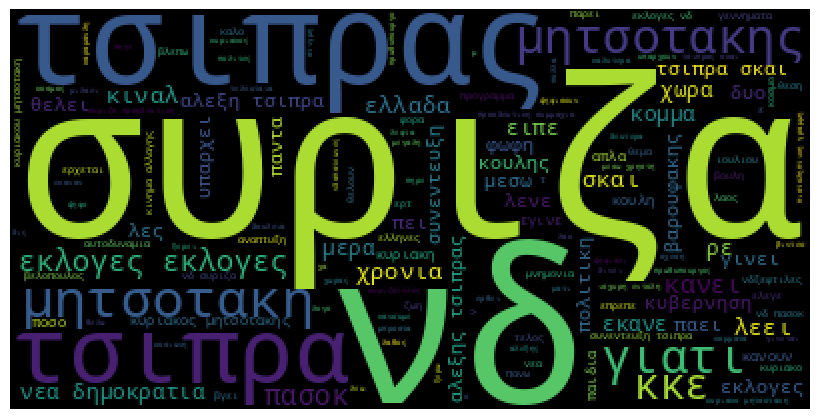

In [10]:
# Creating some visualizations with tokens
# Word cloud
tweets = []
for tweet in df['Text']:
    #tokens.append(doc.text)
    tweets.append(tweet)
    


# stop_words = stopwords.words('greek')
for i in range(len(tweets)):
        tweets[i] = tweets[i].lower()


# remove Diacritics in Greek (tonous)
d = {ord('\N{COMBINING ACUTE ACCENT}'):None}
tweets_string = "".join(tweets)
tweets_without_accent = ud.normalize('NFD',tweets_string).translate(d)


wordcloud = WordCloud(stopwords=stop_words_separated).generate(str(tweets_without_accent))
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

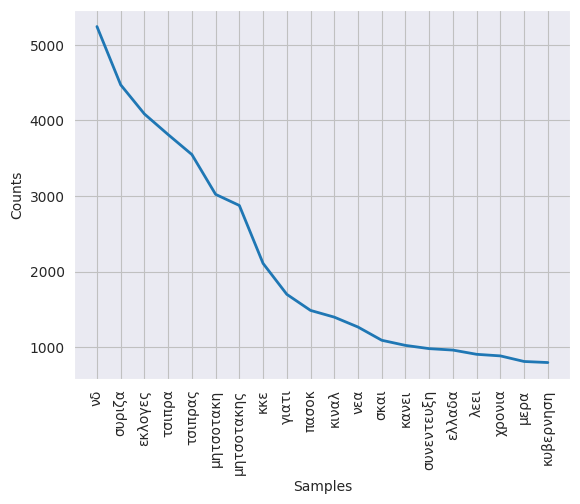

In [11]:
# Tokens frequency diagram
tokens = nltk.word_tokenize(tweets_without_accent)
sns.set_style('darkgrid')
nlp_words=nltk.FreqDist(tokens)
nlp_words.plot(20);

In [12]:
# X = df['Lemmas'] # Lemma as feature, doesn't really increase performance of f1-score.
# X = df['Tokens'] # same as above for tokens.
X_train = df['Text'] # 40% f1-score , best feature as of yet
X_test = test_df['Text']
y_train = df['Sentiment'] # labels

X_valid = valid_df['Text']
y_valid = valid_df['Sentiment'] # these two will be used for metrics

def simple_tokenizer(sentence):
    tokens = sentence.split()  # Split the sentence into a list of words
    return tokens

# tokenize text column and perform below processes for all datasets.
df['Tokens'] = df['Text'].apply(simple_tokenizer)
test_df['Tokens'] = test_df['Text'].apply(simple_tokenizer)
valid_df['Tokens'] = valid_df['Text'].apply(simple_tokenizer)

# Train Word2Vec model
sentences = df['Tokens'].tolist()
test_sentences = test_df['Tokens'].tolist()
valid_sentences = valid_df['Tokens'].tolist()

word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
# test_word2vec_model = Word2Vec(test_sentences, vector_size=100, window=5, min_count=1, workers=4)
# valid_word2vec_model = Word2Vec(valid_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Creates embeddings for each tweet
def get_tweet_embedding(tweet):
    word_embeddings = [word2vec_model.wv[word] for word in tweet if word in word2vec_model.wv]
    if not word_embeddings:
        zeroes_list = [0] * 100
        return zeroes_list
            
#         return None  # Handle the case where no words have embeddings
    tweet_embedding = sum(word_embeddings) / len(word_embeddings)  # Simple average
    return tweet_embedding

# def get_tweet_embedding_test(tweet):
#     word_embeddings = [test_word2vec_model.wv[word] for word in tweet if word in test_word2vec_model.wv]
#     if not word_embeddings:
#         zeroes_list = [0] * 100
#         return zeroes_list
            
# #         return None  # Handle the case where no words have embeddings
#     tweet_embedding = sum(word_embeddings) / len(word_embeddings)  # Simple average
#     return tweet_embedding

# def get_tweet_embedding_valid(tweet):
#     word_embeddings = [valid_word2vec_model.wv[word] for word in tweet if word in valid_word2vec_model.wv]
#     if not word_embeddings:
#         zeroes_list = [0] * 100
#         return zeroes_list
            
# #         return None  # Handle the case where no words have embeddings
#     tweet_embedding = sum(word_embeddings) / len(word_embeddings)  # Simple average
#     return tweet_embedding

# Convert tweet tokens to embeddings
tweet_embeddings_train = [get_tweet_embedding(tweet) for tweet in sentences]
tweet_embeddings_test = [get_tweet_embedding(tweet) for tweet in test_sentences]
tweet_embeddings_valid = [get_tweet_embedding(tweet) for tweet in valid_sentences]


# Convert labels to one-hot encoded tensors
label_embeddings_train = pd.get_dummies(df['Sentiment']).values
label_embeddings_valid = pd.get_dummies(valid_df['Sentiment']).values

# Below part is used to correlate the numbers 0,1,2 to their respective labels (POSITIVE,NEUTRAL,NEGATIVE) for predictions
label_encoded_train = pd.get_dummies(df['Sentiment'])
label_encoded_valid = pd.get_dummies(valid_df['Sentiment'])

label_mapping_train = {i: label for i, label in enumerate(label_encoded_train.columns)}
label_mapping_valid = {i: label for i, label in enumerate(label_encoded_valid.columns)}

# Remove all label embeddings where tweet embeddings has None value
# indexes_to_remove = []
# for i in range(0,len(tweet_embeddings_train)):
#     if tweet_embeddings_train[i] is None:
#         indexes_to_remove.append(i)
    
# valid_indexes_to_remove = []
# for i in range(0,len(tweet_embeddings_valid)):
#     if tweet_embeddings_valid[i] is None:
#         valid_indexes_to_remove.append(i)

# label_embeddings_train = np.delete(label_embeddings, indexes_to_remove, axis=0)
# label_embeddings_valid = np.delete(label_embeddings_valid, valid_indexes_to_remove, axis=0)

# Handle None values (tweets with no words having embeddings) , I have removed 16 tweets that their words had no embeddings.
# tweet_embeddings_train = [emb for emb in tweet_embeddings_train if emb is not None]
# tweet_embeddings_valid = [emb for emb in tweet_embeddings_valid if emb is not None]

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(tweet_embeddings_train)
y_train_tensor = torch.FloatTensor(label_embeddings_train)

X_test_tensor = torch.FloatTensor(tweet_embeddings_test)

X_valid_tensor = torch.FloatTensor(tweet_embeddings_valid)
y_valid_tensor = torch.FloatTensor(label_embeddings_valid)


print('X_train_tensor shape:', X_train_tensor.shape)
print('y_train_tensor shape:', y_train_tensor.shape)

print('X_test_tensor shape: ', X_test_tensor.shape)

print('X_valid_tensor shape: ', X_valid_tensor.shape)
print('y_valid_tensor shape: ', y_valid_tensor.shape)

/tmp/ipykernel_19/552494660.py:95: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X_train_tensor = torch.FloatTensor(tweet_embeddings_train)


X_train_tensor shape: torch.Size([36630, 100])
y_train_tensor shape: torch.Size([36630, 3])
X_test_tensor shape:  torch.Size([10470, 100])
X_valid_tensor shape:  torch.Size([5232, 100])
y_valid_tensor shape:  torch.Size([5232, 3])


## most similar word visualization

In [13]:
# Picking some common words to show visualizations
most_similar_mitsotakis = word2vec_model.wv.most_similar('μητσοτακης')

print(f'Most semantically similar to word Mitsotakis:')
print(f'\n{" "*5}word{" "*10}  similarity score')
print(f'{"="*43}')
for w in most_similar_mitsotakis:
    print(f'{" "*5}{w[0]:15}{w[1]}')

Most semantically similar to word Mitsotakis:

     word            similarity score
     μητσοτακης…    0.9551254510879517
     ζητησε         0.9532033205032349
     ντιξον         0.9503481984138489
     αποδειχθει     0.9468908309936523
     προσφυγικο     0.945105791091919
     συνθεση        0.9412325024604797
     ταξιδευοντας   0.9361863732337952
     χιουγκο        0.9341863393783569
     μειωσουμε      0.932820200920105
     τολμη          0.9320380091667175


In [14]:
most_similar_tsipras = word2vec_model.wv.most_similar('τσιπρας')

print(f'Most semantically similar to word Tsipras:')
print(f'\n{" "*5}word{" "*10}  similarity score')
print(f'{"="*43}')
for w in most_similar_tsipras:
    print(f'{" "*5}{w[0]:15}{w[1]}')

Most semantically similar to word Tsipras:

     word            similarity score
     σκαιτσιπρας    0.9553589820861816
     🔴              0.9534194469451904
     τηλεθεασης     0.9530816078186035
     ζαγορα         0.9527417421340942
     τσιπραςσκαι    0.9513566493988037
     κιν            0.9511148929595947
     σπαει          0.9500080347061157
     πρωινες        0.9495740532875061
     σκαιξεφτιλες   0.948449432849884
     ευχαριστει     0.9474217295646667


## Linear substructure visualization

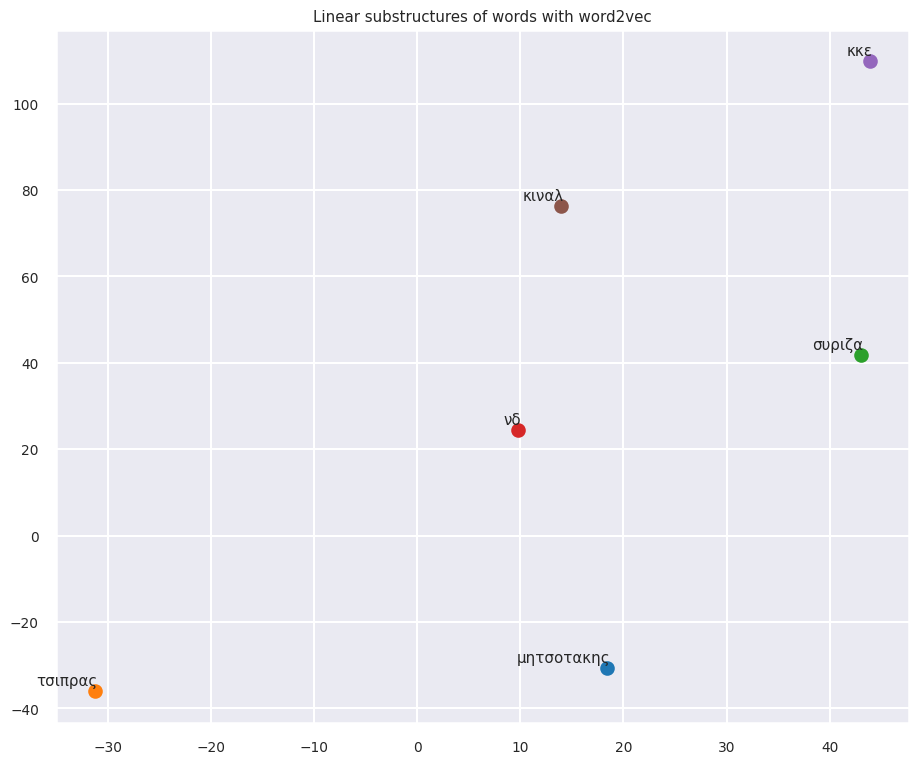

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.manifold import TSNE

sns.set_style("darkgrid")
sns.set_context("talk",  font_scale=0.6)

vocab = ["μητσοτακης", "τσιπρας", "συριζα", "νδ", "κκε", "κιναλ"]

def glove_plot(model):
    labels = []
    wordvecs = []

    for word in vocab:
        wordvecs.append(model.wv[word])
        labels.append(word)
    
    wordvecs_array = np.array(wordvecs)
    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=42) #T-distributed Stochastic Neighbor Embedding
    coordinates = tsne_model.fit_transform(wordvecs_array) #The fit method is calculating the mean and variance of each of the features present in our data. The transform method is transforming all the features using the respective mean and variance.

    x = []
    y = []
    for value in coordinates:
        x.append(value[0])
        y.append(value[1])


    plt.figure(figsize=(11,9))
    plt.title('Linear substructures of words with word2vec')
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(2, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

glove_plot(word2vec_model)

## brute-force Neural network creation

In [16]:
class BF_Net(nn.Module):
    def __init__(self, D_in, H1, H2, H3, H4, D_out):
        super(BF_Net, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, H4)
        self.linear5 = nn.Linear(H4, D_out) # added extra layer not much difference.

    def forward(self, x):
        h1 = self.linear1(x)
        h2 = self.linear2(h1)
        h3 = self.linear3(h2)
        h4 = self.linear4(h3)
        out = self.linear5(h4)
        return out

In [17]:
#Define layer sizes
D_in = X_train_tensor.shape[1]
H1 = 128 #size of the input sample
H2 = 64
H3 = 32
H4 = 16
D_out = 3

#Define Hyperparameters
learning_rate = 1e-4 # You can also experiment with different learning rates

#Initialise model, loss, optimizer
model = BF_Net(D_in, H1, H2, H3, H4, D_out)
loss_func = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam seems the best

#Initialise dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor) #class to represent the data as list of tensors. x=input_features, y=labels
test_dataset = torch.utils.data.TensorDataset(X_test_tensor)
valid_dataset = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)

print("Data loading complete.")

Data loading complete.


In [18]:
# NN training

for epoch in range(16):
    batch_losses = []
    for x_batch, y_batch in train_dataloader:
        y_pred = model(x_batch)

        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # print('y_pred=', y_pred[0])
        #Delete previously stored gradients
        optimizer.zero_grad()
        #Perform backpropagation starting from the loss calculated in this epoch
        
        loss.backward()
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()
    
#     print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_dataloader):.5f}")
    
    model.eval()
    with torch.no_grad():
        valid_batch_losses = []
        for x_batch, y_batch in valid_dataloader:
            y_pred_valid = model(x_batch)
            # Compute and print/validation loss or other metrics
            valid_loss = loss_func(y_pred_valid, y_batch)
            valid_batch_losses.append(valid_loss.item())
    
    print(f'Epoch {epoch:3} \t\t Training Loss: {sum(batch_losses)/len(train_dataloader):.5f} \t\t Validation Loss: {sum(valid_batch_losses) / len(valid_dataloader):.5f}')

Epoch   0 		 Training Loss: 70.15832 		 Validation Loss: 69.79670
Epoch   1 		 Training Loss: 69.90298 		 Validation Loss: 69.62093
Epoch   2 		 Training Loss: 69.81525 		 Validation Loss: 69.63805
Epoch   3 		 Training Loss: 69.77869 		 Validation Loss: 69.55938
Epoch   4 		 Training Loss: 69.75370 		 Validation Loss: 69.54918
Epoch   5 		 Training Loss: 69.74506 		 Validation Loss: 69.57049
Epoch   6 		 Training Loss: 69.74856 		 Validation Loss: 69.54359
Epoch   7 		 Training Loss: 69.71369 		 Validation Loss: 69.56109
Epoch   8 		 Training Loss: 69.72072 		 Validation Loss: 69.50283
Epoch   9 		 Training Loss: 69.69020 		 Validation Loss: 69.52804
Epoch  10 		 Training Loss: 69.67998 		 Validation Loss: 69.49542
Epoch  11 		 Training Loss: 69.69119 		 Validation Loss: 69.47215
Epoch  12 		 Training Loss: 69.68135 		 Validation Loss: 69.44781
Epoch  13 		 Training Loss: 69.66455 		 Validation Loss: 69.47042
Epoch  14 		 Training Loss: 69.66356 		 Validation Loss: 69.43921
Epoch  15 

## Evaluation of the brute-force NN

In [19]:
# Generate test predictions
model.eval()
predictions_test = []

# test results, labels for submission.csv
with torch.no_grad():
    for inputs in test_dataloader:
        for tensor in inputs:
            outputs = model(tensor)
            _, predicted = torch.max(outputs, 1)

            predictions_test.extend(predicted.tolist())
    
# convert 0,1,2 predictions to their original text form (POSITIVE, NEUTRAL , NEGATIVE)
original_label_predictions_test = [label_mapping_train[pred] for pred in predictions_test]
print(len(original_label_predictions_test))
print(original_label_predictions_test[0])


# Generate valid predictions
predictions_valid = []

val_targets = []
model.eval()
# valid results for evaluation
with torch.no_grad():
    for x_batch, y_batch in valid_dataloader:
        outputs = model(x_batch)
        _, predicted = torch.max(outputs, 1)

        predictions_valid.extend(predicted.tolist())
        val_targets.extend(y_batch.tolist())
    
# convert indexes to respective labels and predictions to respective label (POSITIVE, NEGATIVE, NEUTRAL) and feed them to the metric functions 
original_label_predictions_valid = [label_mapping_valid[pred] for pred in predictions_valid]
val_targets_indices = [np.argmax(label) if np.sum(label) > 0 else -1 for label in val_targets]
original_labels_valid = [label_mapping_valid[label] for label in val_targets_indices]

print("\n")
print("================= BRUTE FORCE NEURAL NETWORK SCORES =================")
print(classification_report(original_labels_valid,original_label_predictions_valid))

print("accuracy: ",accuracy_score(original_labels_valid,original_label_predictions_valid))
print("f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average='micro'))
print("total f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average=None))

10470
POSITIVE


================= BRUTE FORCE NEURAL NETWORK SCORES =================
              precision    recall  f1-score   support

    NEGATIVE       0.38      0.47      0.42      1744
     NEUTRAL       0.40      0.21      0.28      1744
    POSITIVE       0.36      0.45      0.40      1744

    accuracy                           0.38      5232
   macro avg       0.38      0.38      0.37      5232
weighted avg       0.38      0.38      0.37      5232

accuracy:  0.3765290519877676
f1:  0.3765290519877676
total f1:  [0.42148338 0.27578391 0.39979524]


## Neural networks with activation functions and dropout layers

In [20]:
# Softmax neural network for MSE Loss function
class Softmax_Net(nn.Module):
    def __init__(self, D_in, H1, H2,dropout_rate, H3, D_out):
        super(Softmax_Net, self).__init__()
        # Softmax and ReLU help the neural network increase the scores a bit
        # but not much to make a tremendous difference.
        self.linear1 = nn.Linear(D_in, H1)
        self.relu = nn.ReLU() # using ReLU
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.dropout = nn.Dropout(p = dropout_rate)
        self.linear4 = nn.Linear(H3, D_out)
        self.softmax = nn.Softmax(dim=-1)  # Softmax layer

    def forward(self, x):
        h1 = self.linear1(x)
        relu = self.relu(h1) 
        h2 = self.linear2(relu)
        relu = self.relu(h2)
        h3 = self.linear3(relu)
        relu = self.relu(h3)
        dropout = self.dropout(relu)
        out_pre_softmax = self.linear4(dropout)
        out = self.softmax(out_pre_softmax)  # Apply softmax to final layer
        return out

In [21]:
# Sigmoid neural network for BCE Loss function
class Sigmoid_Net(nn.Module):
    def __init__(self, D_in, H1, H2,dropout_rate, H3, D_out):
        super(Sigmoid_Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.relu = nn.ReLU() # using ReLU
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.dropout = nn.Dropout(p = dropout_rate)
        self.linear4 = nn.Linear(H3, D_out)
#         self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h1 = self.linear1(x)
        relu = self.relu(h1) 
        h2 = self.linear2(relu)
        h3 = self.linear3(h2)
        dropout = self.dropout(h3)
        out_before_sigmoid = self.linear4(dropout)
        out = torch.sigmoid(out_before_sigmoid) # Apply sigmoid
#         out = self.sigmoid(out_before_sigmoid)  
        return out

In [22]:
# ReLU / Dropout neural network for BCELossWithLogits / CrossEntropyLoss (handles softmax on it's own)
class Relu_Dropout_Net(nn.Module):
    def __init__(self, D_in, H1, H2,dropout_rate, H3, D_out):
        super(Relu_Dropout_Net, self).__init__()
        # Softmax and ReLU help the neural network increase the scores a bit
        # but not much to make a tremendous difference.
        self.linear1 = nn.Linear(D_in, H1)
        self.relu = nn.ReLU() # using ReLU
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.dropout = nn.Dropout(p = dropout_rate)
        self.linear4 = nn.Linear(H3, D_out)

    def forward(self, x):
        h1 = self.linear1(x)
        relu = self.relu(h1) 
        h2 = self.linear2(relu)
        h3 = self.linear3(h2)
        dropout = self.dropout(h3)
        out = self.linear4(dropout)
        return out

## Softmax NN training and evaluation

In [23]:
#Define layer sizes
D_in = X_train_tensor.shape[1]
H1 = 128 #size of the input sample
H2 = 64
dropout_rate = 0.3
H3 = 32
D_out = 3

#Define Hyperparameters
learning_rate = 1e-3 # best LR yet: 1e-3

#Initialise model, loss, optimizer
model = Softmax_Net(D_in, H1, H2,dropout_rate, H3, D_out)
loss_func = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam, SGD, AdamW

#Initialise dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor) #class to represent the data as list of tensors. x=input_features, y=labels
test_dataset = torch.utils.data.TensorDataset(X_test_tensor)
valid_dataset = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)

print("Data loading complete.")

# NN training

for epoch in range(16):
    batch_losses = []
    for x_batch, y_batch in train_dataloader:
        y_pred = model(x_batch)

        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # print('y_pred=', y_pred[0])
        #Delete previously stored gradients
        optimizer.zero_grad()
        #Perform backpropagation starting from the loss calculated in this epoch
        
        loss.backward()
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()
    
#     print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_dataloader):.5f}")
    
    model.eval()
    with torch.no_grad():
        valid_batch_losses = []
        for x_batch, y_batch in valid_dataloader:
            y_pred_valid = model(x_batch)
            # Compute and print/validation loss or other metrics
            valid_loss = loss_func(y_pred_valid, y_batch)
            valid_batch_losses.append(valid_loss.item())
    
    print(f'Epoch {epoch:3} \t\t Training Loss: {sum(batch_losses)/len(train_dataloader):.5f} \t\t Validation Loss: {sum(valid_batch_losses) / len(valid_dataloader):.5f}')
    

# Generate test predictions
model.eval()
predictions_test = []

# test results, labels for submission.csv
with torch.no_grad():
    for inputs in test_dataloader:
        for tensor in inputs:
            outputs = model(tensor)
            _, predicted = torch.max(outputs, 1)

            predictions_test.extend(predicted.tolist())
    
# convert 0,1,2 predictions to their original text form (POSITIVE, NEUTRAL , NEGATIVE)
original_label_predictions_test = [label_mapping_train[pred] for pred in predictions_test]
print(len(original_label_predictions_test))
print(original_label_predictions_test[0])

# Generate valid predictions
predictions_valid = []

val_targets = []
model.eval()
# valid results for evaluation
with torch.no_grad():
    for x_batch, y_batch in valid_dataloader:
        outputs = model(x_batch)
        _, predicted = torch.max(outputs, 1)

        predictions_valid.extend(predicted.tolist())
        val_targets.extend(y_batch.tolist())
    
# convert indexes to respective labels and predictions to respective label (POSITIVE, NEGATIVE, NEUTRAL) and feed them to the metric functions 
original_label_predictions_valid = [label_mapping_valid[pred] for pred in predictions_valid]
val_targets_indices = [np.argmax(label) if np.sum(label) > 0 else -1 for label in val_targets]
original_labels_valid = [label_mapping_valid[label] for label in val_targets_indices]

print("\n")
print("================= SOFTMAX NN SCORES =================")
print(classification_report(original_labels_valid,original_label_predictions_valid))

print("accuracy: ",accuracy_score(original_labels_valid,original_label_predictions_valid))
print("f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average='micro'))
print("total f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average=None))

Data loading complete.
Epoch   0 		 Training Loss: 0.22152 		 Validation Loss: 0.22036
Epoch   1 		 Training Loss: 0.22067 		 Validation Loss: 0.22027
Epoch   2 		 Training Loss: 0.22021 		 Validation Loss: 0.22006
Epoch   3 		 Training Loss: 0.21987 		 Validation Loss: 0.21928
Epoch   4 		 Training Loss: 0.21961 		 Validation Loss: 0.21844
Epoch   5 		 Training Loss: 0.21931 		 Validation Loss: 0.21854
Epoch   6 		 Training Loss: 0.21900 		 Validation Loss: 0.21842
Epoch   7 		 Training Loss: 0.21881 		 Validation Loss: 0.21830
Epoch   8 		 Training Loss: 0.21867 		 Validation Loss: 0.21876
Epoch   9 		 Training Loss: 0.21857 		 Validation Loss: 0.21840
Epoch  10 		 Training Loss: 0.21847 		 Validation Loss: 0.21780
Epoch  11 		 Training Loss: 0.21847 		 Validation Loss: 0.21769
Epoch  12 		 Training Loss: 0.21828 		 Validation Loss: 0.21745
Epoch  13 		 Training Loss: 0.21805 		 Validation Loss: 0.21768
Epoch  14 		 Training Loss: 0.21807 		 Validation Loss: 0.21799
Epoch  15 		 Trai

## Sigmoid NN training and evaluation

In [24]:
#Define layer sizes
D_in = X_train_tensor.shape[1]
H1 = 128 #size of the input sample
H2 = 64
dropout_rate = 0.3
H3 = 32
D_out = 3

#Define Hyperparameters
learning_rate = 1e-3 # You can also experiment with different learning rates


#Initialise model, loss, optimizer
model = Sigmoid_Net(D_in, H1, H2,dropout_rate, H3, D_out)
loss_func = nn.BCELoss(reduction='sum') # Only BCELoss here.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Initialise dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor) #class to represent the data as list of tensors. x=input_features, y=labels
test_dataset = torch.utils.data.TensorDataset(X_test_tensor)
valid_dataset = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)

print("Data loading complete.")

# NN training

for epoch in range(16):
    batch_losses = []
    for x_batch, y_batch in train_dataloader:
        y_pred = model(x_batch)

        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # print('y_pred=', y_pred[0])
        #Delete previously stored gradients
        optimizer.zero_grad()
        #Perform backpropagation starting from the loss calculated in this epoch
        
        loss.backward()
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()
    
#     print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_dataloader):.5f}")
    
    model.eval()
    with torch.no_grad():
        valid_batch_losses = []
        for x_batch, y_batch in valid_dataloader:
            y_pred_valid = model(x_batch)
            # Compute and print/validation loss or other metrics
            valid_loss = loss_func(y_pred_valid, y_batch)
            valid_batch_losses.append(valid_loss.item())
    
    print(f'Epoch {epoch:3} \t\t Training Loss: {sum(batch_losses)/len(train_dataloader):.5f} \t\t Validation Loss: {sum(valid_batch_losses) / len(valid_dataloader):.5f}')

# Generate test predictions
model.eval()
predictions_test = []

# test results, labels for submission.csv
with torch.no_grad():
    for inputs in test_dataloader:
        for tensor in inputs:
            outputs = model(tensor)
            _, predicted = torch.max(outputs, 1)

            predictions_test.extend(predicted.tolist())
    
# convert 0,1,2 predictions to their original text form (POSITIVE, NEUTRAL , NEGATIVE)
original_label_predictions_test = [label_mapping_train[pred] for pred in predictions_test]
print(len(original_label_predictions_test))
print(original_label_predictions_test[0])

# Generate valid predictions
predictions_valid = []

val_targets = []
model.eval()
# valid results for evaluation
with torch.no_grad():
    for x_batch, y_batch in valid_dataloader:
        outputs = model(x_batch)
        _, predicted = torch.max(outputs, 1)

        predictions_valid.extend(predicted.tolist())
        val_targets.extend(y_batch.tolist())
    
# convert indexes to respective labels and predictions to respective label (POSITIVE, NEGATIVE, NEUTRAL) and feed them to the metric functions 
original_label_predictions_valid = [label_mapping_valid[pred] for pred in predictions_valid]
val_targets_indices = [np.argmax(label) if np.sum(label) > 0 else -1 for label in val_targets]
original_labels_valid = [label_mapping_valid[label] for label in val_targets_indices]

print("\n")
print("================= SIGMOID NN SCORES (BCE LOSS) =================")
print(classification_report(original_labels_valid,original_label_predictions_valid))

print("accuracy: ",accuracy_score(original_labels_valid,original_label_predictions_valid))
print("f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average='micro'))
print("total f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average=None))

Data loading complete.
Epoch   0 		 Training Loss: 122.29854 		 Validation Loss: 121.28755
Epoch   1 		 Training Loss: 121.39531 		 Validation Loss: 121.11243
Epoch   2 		 Training Loss: 121.22901 		 Validation Loss: 120.96743
Epoch   3 		 Training Loss: 121.18393 		 Validation Loss: 120.72441
Epoch   4 		 Training Loss: 121.03865 		 Validation Loss: 120.63181
Epoch   5 		 Training Loss: 120.99433 		 Validation Loss: 120.42483
Epoch   6 		 Training Loss: 120.84099 		 Validation Loss: 120.30736
Epoch   7 		 Training Loss: 120.79683 		 Validation Loss: 120.16042
Epoch   8 		 Training Loss: 120.70949 		 Validation Loss: 120.18002
Epoch   9 		 Training Loss: 120.70321 		 Validation Loss: 120.12799
Epoch  10 		 Training Loss: 120.61886 		 Validation Loss: 120.15078
Epoch  11 		 Training Loss: 120.63061 		 Validation Loss: 120.13527
Epoch  12 		 Training Loss: 120.56295 		 Validation Loss: 120.20092
Epoch  13 		 Training Loss: 120.52984 		 Validation Loss: 119.94938
Epoch  14 		 Training Los

## ReLU and Dropout layer NN training and evaluation (BCE Loss with Logits)

In [25]:
#Define layer sizes
D_in = X_train_tensor.shape[1]
H1 = 128 #size of the input sample
H2 = 64
dropout_rate = 0.5
H3 = 32
D_out = 3

#Define Hyperparameters
learning_rate = 1e-4 # You can also experiment with different learning rates

#Initialise model, loss, optimizer
model = Relu_Dropout_Net(D_in, H1, H2,dropout_rate, H3, D_out)
loss_func = nn.BCEWithLogitsLoss(reduction='sum') # You can also try BCELoss and BCEWithLogitsLoss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # You can also try Adam and AdamW

#Initialise dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor) #class to represent the data as list of tensors. x=input_features, y=labels
test_dataset = torch.utils.data.TensorDataset(X_test_tensor)
valid_dataset = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)

print("Data loading complete.")

# NN training

for epoch in range(16):
    batch_losses = []
    for x_batch, y_batch in train_dataloader:
        y_pred = model(x_batch)

        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # print('y_pred=', y_pred[0])
        #Delete previously stored gradients
        optimizer.zero_grad()
        #Perform backpropagation starting from the loss calculated in this epoch
        
        loss.backward()
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()
    
#     print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_dataloader):.5f}")
    
    model.eval()
    with torch.no_grad():
        valid_batch_losses = []
        for x_batch, y_batch in valid_dataloader:
            y_pred_valid = model(x_batch)
            # Compute and print/validation loss or other metrics
            valid_loss = loss_func(y_pred_valid, y_batch)
            valid_batch_losses.append(valid_loss.item())
    
    print(f'Epoch {epoch:3} \t\t Training Loss: {sum(batch_losses)/len(train_dataloader):.5f} \t\t Validation Loss: {sum(valid_batch_losses) / len(valid_dataloader):.5f}')

# Generate test predictions
model.eval()
predictions_test = []

# test results, labels for submission.csv
with torch.no_grad():
    for inputs in test_dataloader:
        for tensor in inputs:
            outputs = model(tensor)
            _, predicted = torch.max(outputs, 1)

            predictions_test.extend(predicted.tolist())
    
# convert 0,1,2 predictions to their original text form (POSITIVE, NEUTRAL , NEGATIVE)
original_label_predictions_test = [label_mapping_train[pred] for pred in predictions_test]
print(len(original_label_predictions_test))
print(original_label_predictions_test[0])

# Generate valid predictions
predictions_valid = []

val_targets = []
model.eval()
# valid results for evaluation
with torch.no_grad():
    for x_batch, y_batch in valid_dataloader:
        outputs = model(x_batch)
        _, predicted = torch.max(outputs, 1)

        predictions_valid.extend(predicted.tolist())
        val_targets.extend(y_batch.tolist())
    
# convert indexes to respective labels and predictions to respective label (POSITIVE, NEGATIVE, NEUTRAL) and feed them to the metric functions 
original_label_predictions_valid = [label_mapping_valid[pred] for pred in predictions_valid]
val_targets_indices = [np.argmax(label) if np.sum(label) > 0 else -1 for label in val_targets]
original_labels_valid = [label_mapping_valid[label] for label in val_targets_indices]

print("\n")
print("================= RELU AND DROPOUT NN SCORES (BCE LOSS WITH LOGITS) =================")
print(classification_report(original_labels_valid,original_label_predictions_valid))

print("accuracy: ",accuracy_score(original_labels_valid,original_label_predictions_valid))
print("f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average='micro'))
print("total f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average=None))

Data loading complete.
Epoch   0 		 Training Loss: 124.93669 		 Validation Loss: 122.10414
Epoch   1 		 Training Loss: 121.95032 		 Validation Loss: 121.29727
Epoch   2 		 Training Loss: 121.52000 		 Validation Loss: 121.08000
Epoch   3 		 Training Loss: 121.39199 		 Validation Loss: 121.05438
Epoch   4 		 Training Loss: 121.31711 		 Validation Loss: 120.98420
Epoch   5 		 Training Loss: 121.26727 		 Validation Loss: 120.96653
Epoch   6 		 Training Loss: 121.24640 		 Validation Loss: 120.89237
Epoch   7 		 Training Loss: 121.21852 		 Validation Loss: 120.90182
Epoch   8 		 Training Loss: 121.19922 		 Validation Loss: 120.87025
Epoch   9 		 Training Loss: 121.17615 		 Validation Loss: 121.02514
Epoch  10 		 Training Loss: 121.14257 		 Validation Loss: 120.82876
Epoch  11 		 Training Loss: 121.11704 		 Validation Loss: 120.81860
Epoch  12 		 Training Loss: 121.09429 		 Validation Loss: 120.79366
Epoch  13 		 Training Loss: 121.05608 		 Validation Loss: 120.74966
Epoch  14 		 Training Los

## ReLU and Dropout layer NN training and evaluation (Cross Entropy Loss)

In [26]:
#Define layer sizes
D_in = X_train_tensor.shape[1]
H1 = 128 #size of the input sample
H2 = 64
dropout_rate = 0.5
H3 = 32
D_out = 3

#Define Hyperparameters
learning_rate = 1e-4 # You can also experiment with different learning rates

#Initialise model, loss, optimizer
model = Relu_Dropout_Net(D_in, H1, H2,dropout_rate, H3, D_out)
loss_func = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # You can also try Adam and AdamW

#Initialise dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor) #class to represent the data as list of tensors. x=input_features, y=labels
test_dataset = torch.utils.data.TensorDataset(X_test_tensor)
valid_dataset = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)

print("Data loading complete.")

# NN training

for epoch in range(16):
    batch_losses = []
    for x_batch, y_batch in train_dataloader:
        y_pred = model(x_batch)

        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # print('y_pred=', y_pred[0])
        #Delete previously stored gradients
        optimizer.zero_grad()
        #Perform backpropagation starting from the loss calculated in this epoch
        
        loss.backward()
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()
    
#     print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_dataloader):.5f}")
    
    model.eval()
    with torch.no_grad():
        valid_batch_losses = []
        for x_batch, y_batch in valid_dataloader:
            y_pred_valid = model(x_batch)
            # Compute and print/validation loss or other metrics
            valid_loss = loss_func(y_pred_valid, y_batch)
            valid_batch_losses.append(valid_loss.item())
    
    print(f'Epoch {epoch:3} \t\t Training Loss: {sum(batch_losses)/len(train_dataloader):.5f} \t\t Validation Loss: {sum(valid_batch_losses) / len(valid_dataloader):.5f}')

# Generate test predictions
model.eval()
predictions_test = []

# test results, labels for submission.csv
with torch.no_grad():
    for inputs in test_dataloader:
        for tensor in inputs:
            outputs = model(tensor)
            _, predicted = torch.max(outputs, 1)

            predictions_test.extend(predicted.tolist())
    
# convert 0,1,2 predictions to their original text form (POSITIVE, NEUTRAL , NEGATIVE)
original_label_predictions_test = [label_mapping_train[pred] for pred in predictions_test]
print(len(original_label_predictions_test))
print(original_label_predictions_test[0])

# Generate valid predictions
predictions_valid = []

val_targets = []
model.eval()
# valid results for evaluation
with torch.no_grad():
    for x_batch, y_batch in valid_dataloader:
        outputs = model(x_batch)
        _, predicted = torch.max(outputs, 1)

        predictions_valid.extend(predicted.tolist())
        val_targets.extend(y_batch.tolist())
    
# convert indexes to respective labels and predictions to respective label (POSITIVE, NEGATIVE, NEUTRAL) and feed them to the metric functions 
original_label_predictions_valid = [label_mapping_valid[pred] for pred in predictions_valid]
val_targets_indices = [np.argmax(label) if np.sum(label) > 0 else -1 for label in val_targets]
original_labels_valid = [label_mapping_valid[label] for label in val_targets_indices]

print("\n")
print("================= RELU AND DROPOUT NN SCORES (CROSS ENTROPY LOSS) =================")
print(classification_report(original_labels_valid,original_label_predictions_valid))

print("accuracy: ",accuracy_score(original_labels_valid,original_label_predictions_valid))
print("f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average='micro'))
print("total f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average=None))

Data loading complete.
Epoch   0 		 Training Loss: 70.13426 		 Validation Loss: 69.68891
Epoch   1 		 Training Loss: 69.83775 		 Validation Loss: 69.56847
Epoch   2 		 Training Loss: 69.72776 		 Validation Loss: 69.50195
Epoch   3 		 Training Loss: 69.66827 		 Validation Loss: 69.46709
Epoch   4 		 Training Loss: 69.64266 		 Validation Loss: 69.45947
Epoch   5 		 Training Loss: 69.63108 		 Validation Loss: 69.42470
Epoch   6 		 Training Loss: 69.60747 		 Validation Loss: 69.47237
Epoch   7 		 Training Loss: 69.59003 		 Validation Loss: 69.39223
Epoch   8 		 Training Loss: 69.55986 		 Validation Loss: 69.37388
Epoch   9 		 Training Loss: 69.54846 		 Validation Loss: 69.35257
Epoch  10 		 Training Loss: 69.52747 		 Validation Loss: 69.42441
Epoch  11 		 Training Loss: 69.51117 		 Validation Loss: 69.34213
Epoch  12 		 Training Loss: 69.49237 		 Validation Loss: 69.30209
Epoch  13 		 Training Loss: 69.45421 		 Validation Loss: 69.35440
Epoch  14 		 Training Loss: 69.44088 		 Validation Lo

## Optuna hyperparameter tuning for NNs

In [27]:
def suggest_hyperparameters(trial): #function to include the suggested hyperparameters
    # Experimenting with different optimizers
    optimizer_name = trial.suggest_categorical("optimizer_name", ["Adam", "AdamW"])
    return optimizer_name

#Optuna sample

c = 0
def objective(trial):
    optimizer_name = suggest_hyperparameters(trial)
    # I'm gonna use the ReLU / softmax NN to see the results
    D_in = X_train_tensor.shape[1]
    H1 = 128 #size of the input sample
    H2 = 64

#     dropout_rate = 0.5
    H3 = 32
    D_out = 3
    
    #Define Hyperparameters
#     learning_rate = 1e-3 # You can also experiment with different learning rates
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-1, log=True) # experimenting with different learning rates
    dropout_rate = trial.suggest_float("dropout_rate", 0.0 , 0.5) # experimenting with different dropout rates

    #Initialise model, loss, optimizer
    model = Softmax_Net(D_in, H1, H2,dropout_rate, H3, D_out)
    loss_func = nn.MSELoss()
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "AdamW":
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # You can also try Adam and AdamW

    #Initialise dataloader with valid_set
    dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor) #class to represent the data as list of tensors. x=input_features, y=labels
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
    for epoch in range(5):
        batch_losses = []

        for x_batch, y_batch in dataloader:
            y_pred = model(x_batch)

            loss = loss_func(y_pred, y_batch)
            batch_losses.append(loss.item())
            # print('y_pred=', y_pred[0])
            #Delete previously stored gradients
            optimizer.zero_grad()
            #Perform backpropagation starting from the loss calculated in this epoch
            loss.backward()
            #Update model's weights based on the gradients calculated during backprop
            optimizer.step()

#         print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(dataloader):.5f}")
        epoch_loss = sum(batch_losses)/len(dataloader)
    global c
    print('trial ' , c , 'is done.')
    c += 1
    return epoch_loss

optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information
optuna_sample = optuna.create_study(direction = 'minimize' , study_name = 'lr-minim-sample')
optuna_sample.optimize(objective, n_trials = 50) #the first parameter is the function that we want to optimise
print('numbers of the finished trials:' , len(optuna_sample.trials))
print('the best params:' , optuna_sample.best_trial.params)
print('the best value:' , optuna_sample.best_value)


trial  0 is done.
trial  1 is done.
trial  2 is done.
trial  3 is done.
trial  4 is done.
trial  5 is done.
trial  6 is done.
trial  7 is done.
trial  8 is done.
trial  9 is done.
trial  10 is done.
trial  11 is done.
trial  12 is done.
trial  13 is done.
trial  14 is done.
trial  15 is done.
trial  16 is done.
trial  17 is done.
trial  18 is done.
trial  19 is done.
trial  20 is done.
trial  21 is done.
trial  22 is done.
trial  23 is done.
trial  24 is done.
trial  25 is done.
trial  26 is done.
trial  27 is done.
trial  28 is done.
trial  29 is done.
trial  30 is done.
trial  31 is done.
trial  32 is done.
trial  33 is done.
trial  34 is done.
trial  35 is done.
trial  36 is done.
trial  37 is done.
trial  38 is done.
trial  39 is done.
trial  40 is done.
trial  41 is done.
trial  42 is done.
trial  43 is done.
trial  44 is done.
trial  45 is done.
trial  46 is done.
trial  47 is done.
trial  48 is done.
trial  49 is done.
numbers of the finished trials: 50
the best params: {'optimi

In [28]:
#Define layer sizes
D_in = X_train_tensor.shape[1]
H1 = 64 #size of the input sample
H2 = 32
dropout_rate = 0.3 # best dropout
# dropout_rate = 0.00442345304572124 
H3 = 16
D_out = 3


#Define Hyperparameters
# learning_rate = 0.0008299314245515878 
learning_rate = 1e-3 # best LR value


#Initialise model, loss, optimizer
model = Softmax_Net(D_in, H1, H2,dropout_rate, H3, D_out)
loss_func = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # For optimizers Adam is the best

#Initialise dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor) #class to represent the data as list of tensors. x=input_features, y=labels
test_dataset = torch.utils.data.TensorDataset(X_test_tensor)
valid_dataset = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)

print("Data loading complete.")

# NN training

for epoch in range(16):
    batch_losses = []
    for x_batch, y_batch in train_dataloader:
        y_pred = model(x_batch)

        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # print('y_pred=', y_pred[0])
        #Delete previously stored gradients
        optimizer.zero_grad()
        #Perform backpropagation starting from the loss calculated in this epoch
        
        loss.backward()
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()
    
#     print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_dataloader):.5f}")
    
    model.eval()
    with torch.no_grad():
        valid_batch_losses = []
        for x_batch, y_batch in valid_dataloader:
            y_pred_valid = model(x_batch)
            # Compute and print/validation loss or other metrics
            valid_loss = loss_func(y_pred_valid, y_batch)
            valid_batch_losses.append(valid_loss.item())
    
    # Check validation loss to make sure we don't get overfitting
    print(f'Epoch {epoch:3} \t\t Training Loss: {sum(batch_losses)/len(train_dataloader):.5f} \t\t Validation Loss: {sum(valid_batch_losses) / len(valid_dataloader):.5f}')
    


    
# Generate test predictions and evaluate test set
model.eval()
predictions_test = []

# test results, labels for submission.csv
with torch.no_grad():
    for inputs in test_dataloader:
        for tensor in inputs:
            outputs = model(tensor)
            _, predicted = torch.max(outputs, 1)

            predictions_test.extend(predicted.tolist())
    
# convert 0,1,2 predictions to their original text form (POSITIVE, NEUTRAL , NEGATIVE)
# these will also be put in the submission.csv
original_label_predictions_test_best_hyper = [label_mapping_train[pred] for pred in predictions_test]

# Generate valid predictions
predictions_valid = []

val_targets = []
model.eval()
# valid results for evaluation
with torch.no_grad():
    for x_batch, y_batch in valid_dataloader:
        outputs = model(x_batch)
        _, predicted = torch.max(outputs, 1)

        predictions_valid.extend(predicted.tolist())
        val_targets.extend(y_batch.tolist())
    
# convert indexes to respective labels and predictions to respective label (POSITIVE, NEGATIVE, NEUTRAL) and feed them to the metric functions 
original_label_predictions_valid = [label_mapping_valid[pred] for pred in predictions_valid]
val_targets_indices = [np.argmax(label) if np.sum(label) > 0 else -1 for label in val_targets]
original_labels_valid = [label_mapping_valid[label] for label in val_targets_indices]

print("\n")
print("================= BEST HYPERPARAMETER SOFTMAX NN SCORES =================")
print(classification_report(original_labels_valid,original_label_predictions_valid))

print("accuracy: ",accuracy_score(original_labels_valid,original_label_predictions_valid))
print("f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average='micro'))
print("total f1: ",f1_score(original_labels_valid,original_label_predictions_valid,average=None))

Data loading complete.
Epoch   0 		 Training Loss: 0.22184 		 Validation Loss: 0.22110
Epoch   1 		 Training Loss: 0.22076 		 Validation Loss: 0.22022
Epoch   2 		 Training Loss: 0.22050 		 Validation Loss: 0.22012
Epoch   3 		 Training Loss: 0.22025 		 Validation Loss: 0.22004
Epoch   4 		 Training Loss: 0.21998 		 Validation Loss: 0.21919
Epoch   5 		 Training Loss: 0.21979 		 Validation Loss: 0.21909
Epoch   6 		 Training Loss: 0.21957 		 Validation Loss: 0.21877
Epoch   7 		 Training Loss: 0.21928 		 Validation Loss: 0.21846
Epoch   8 		 Training Loss: 0.21918 		 Validation Loss: 0.21838
Epoch   9 		 Training Loss: 0.21886 		 Validation Loss: 0.21783
Epoch  10 		 Training Loss: 0.21867 		 Validation Loss: 0.21816
Epoch  11 		 Training Loss: 0.21855 		 Validation Loss: 0.21811
Epoch  12 		 Training Loss: 0.21843 		 Validation Loss: 0.21813
Epoch  13 		 Training Loss: 0.21834 		 Validation Loss: 0.21797
Epoch  14 		 Training Loss: 0.21828 		 Validation Loss: 0.21755
Epoch  15 		 Trai

In [29]:
conf_matrix = confusion_matrix(y_valid,original_label_predictions_valid)
print(confusion_matrix(y_valid,original_label_predictions_valid))

[[961 329 454]
 [946 334 464]
 [934 317 493]]


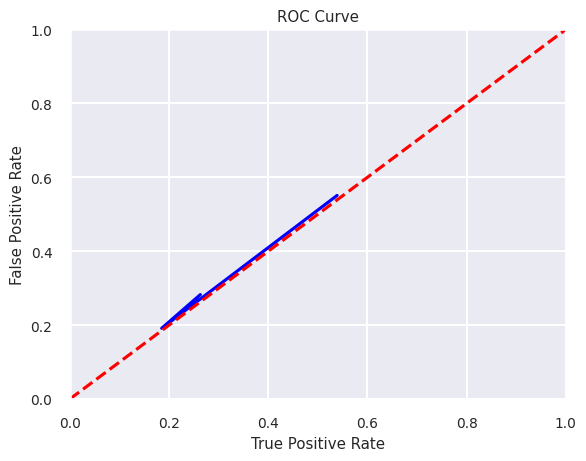

In [30]:
# ROC Curve
FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix) #false positive
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix) # false negative
TP = np.diag(conf_matrix) # true positive
TN = conf_matrix.sum() - (FP + FN + TP) # True negative

TPR = TP/(TP+FN) # true positive rate
FPR = FP/(FP+TN) # false positive rate

plt.plot(FPR,TPR,'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

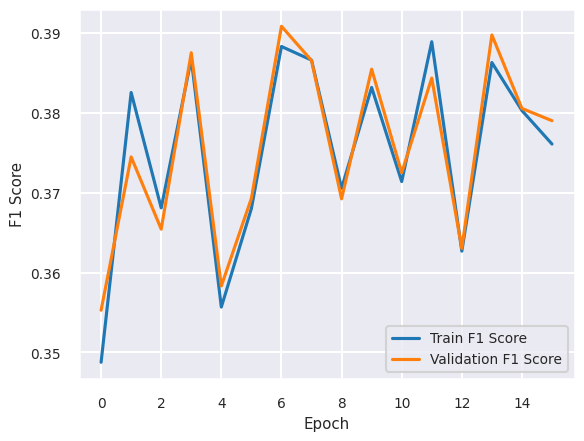

In [31]:
# Learning curve for ReLU / Dropout NN
train_f1_scores = []
val_f1_scores = []

for epoch in range(16):
    batch_losses = []
    for x_batch, y_batch in train_dataloader:
        y_pred = model(x_batch)

        loss = loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())
        # print('y_pred=', y_pred[0])
        #Delete previously stored gradients
        optimizer.zero_grad()
        #Perform backpropagation starting from the loss calculated in this epoch
        
        loss.backward()
        #Update model's weights based on the gradients calculated during backprop
        optimizer.step()
    
#     print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(train_dataloader):.5f}")

    # Evaluation on training set
    model.eval()
    train_predictions = []
    train_targets = []
    with torch.no_grad():
        for inputs, labels in train_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Append predictions and targets for f1_score calculation
            train_predictions.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())
            
    train_targets_indices = [np.argmax(label) if np.sum(label) > 0 else -1 for label in train_targets]
    train_f1 = f1_score(train_targets_indices, train_predictions, average='macro')
    train_f1_scores.append(train_f1)
    
    # Evaluation on valid set
    model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for inputs, labels in valid_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Append predictions and targets for f1_score calculation
            val_predictions.extend(predicted.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
            
    val_targets_indices = [np.argmax(label) if np.sum(label) > 0 else -1 for label in val_targets]
    val_f1 = f1_score(val_targets_indices, val_predictions, average='macro')
    val_f1_scores.append(val_f1)
    

# Plot the learning curve
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

## Output file

In [32]:
import csv

with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    
    writer.writerow(["Id","Predicted"])
    for i in range(0,10470):
        writer.writerow([i+1,original_label_predictions_test_best_hyper[i]])  
    
    
print("CSV file writing complete.")

CSV file writing complete.
